In [1]:
#!/usr/bin/env python3

import sys
import pickle
import re
import os
import csv
import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import scipy.stats as st

# Demand Python 3.
if sys.version_info[0] < 3:
    print("Python 3 is required, but you are using Python %i.%i.%i") % (
        sys.version_info[0], sys.version_info[1], sys.version_info[2])
    sys.exit(1)

We need to change directory to wherever the input files are located.

In [2]:
os.chdir("/mnt/c//Users/Maya/Dropbox/PTE_results")

In [3]:
# Later, load in the results for analysis
with open('S6_full_all.p', 'rb') as f:
    all_ref = pickle.load(f)

In [4]:
print(all_ref['S6'].keys())

dict_keys(['d9', 'd6', 'i6', 'd3', 'i3', 'i9'])


The `all_ref` dictionary contains all information collected from sequenced, aggregated by protein background (here wtPTE, dubbed S6 for all fractions) and then by fraction / type of library. There is no filterin on this point, so `all_ref` includes all sequencing error, frameshifts, variants with extra point mutations etc.

Each key in the dictionary takes the format:

```
protein_mutation : {'total': integer_count, 
                    'dna_hgvs': {'dna_in_HGVS_format': count},
                    'dna': {'dna_in_tuple_format': count} # this is for each DNA mutation that generates that protein mutation
                   }
```
So, if we want to know all mutations in a certain position in a library, we need `all_ref['S6']['d3](protein_tuple)['dna'].items()` or some such.

In [5]:
def classify_dna(dna_error):
    """
    Given a dna_error tuple, it describes the type of mutation: 
    d(eletion), i(nsertion), s(ubstitution), f(rameshift), b(roken), wt 
    or a combination of these.
    """
    if dna_error is None:  # empty or broken reads
        return 'b'
    elif dna_error == ():
        return 'wt'
    elif len(dna_error) > 1:
        # expect substitutions
        if dna_error[-1][1] == 'f':  # frameshifts are always the last mutation
            return 'f'
        else:
            for k in range(len(dna_error)):
                if dna_error[k][1] == 'i':
                    return 'si'
                elif dna_error[k][1] == 'd':
                    return 'sd'
            return 's'
    elif len(dna_error) == 1:
        if dna_error[0][1] == 'f':
            return 'f'
        elif dna_error[0][1] == 'd':
            return 'd' + dna_error[0][2]  # length of deletion
        elif dna_error[0][1] == 'i':
            return 'i' + str(len(dna_error[0][2]))
        elif dna_error[0][1] == 's':
            return 's'
    else:
        return 'b'

def classify_protein(mutation):
    """
    Detect whether a protein mutation is an insertion/deletion/substituion and if more than 1, (non)consecutive
    :param mutation:
    :return:
    """
    if mutation is None:  # came from empty or broken reads
        return 'b'
    elif mutation == ():
        return 'b'
    else:
        m = []
        for pos in range(len(mutation)):
            t = mutation[pos][1]
            if t != 'i':
                m.append(t)
            else:
                m.append(t + str(len(mutation[pos][2])))
        # need to distinguish between consecutive mutations and likely sequencing errors
        if 'f' in m:
            return 'f'
        elif len(m) == 1:
            if mutation[0][-1] == '*':
                return '*'
            else:
                return ''.join(m)
        elif len(m) >= 1:
            if mutation[-1][-1] == '*':
                return '*'
            else:
                c = is_mutation_consecutive(mutation) + '-' + ''.join(m)
                return c


def is_mutation_consecutive(mutation):
    """
    If only consecutve amino acids are affected, return 'c', else return 'nc'
    :param mutation:
    :return:
    """
    for pos in range(1, len(mutation)):
        if mutation[pos][0] != (mutation[pos - 1][0] + 1) :
            return 'nc'
    return 'c'


def dna_protein_correspondence(dna_type):
    """
    Given a type of dna mutation (d3, d6 etc.), it translates this
    into what effect this should have on protein for target mutations.
    """
    dna_to_prot_type = {'d3':['d', 'c-sd', '*'], 'd6':['c-dd', 'c-sdd', '*'], 'd9':['c-ddd', 'c-sddd', '*'],
                        'i3':['i1','c-si1', '*'], 'i6': ['i2','c-si2', '*'], 'i9':['i3','c-si3', '*']
                       }
    
    try:
        return dna_to_prot_type[dna_type]
    except KeyError:
        return []       

In [6]:
def get_dna_composition(all_references, cutoff=10):
    """
    Classify all detected mutations by what kind they are: substitution, deletion, insertion (including length), frameshift, or other.
    Collect the results in a dataframe, both for mutation counts and associated sequencing reads.
    Relatively simple logic because two different DNA mutations can give rise to one protein mutation, but not vice versa.
    """

    dna_count = {}
    dna_reads = {}
    
    dna_to_stop = {'d3': 0, 'd6': 0, 'd9': 0}
    
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            # print('Analysing background {0} and fraction {1}. Unusal mutations: '.format(background, fraction))
            distinct_mutations = 0
            total_count = 0
            dna_count[background + '.' + fraction] = {'s': 0, 'd3': 0, 'd6': 0, 'd9': 0, 'i3': 0, 'i6': 0, 'i9': 0, 'f': 0,
                                                'b': 0, 'other': 0, 'sd': 0, 'si': 0}
            dna_reads[background + '.' + fraction] = {'s': 0, 'd3': 0, 'd6': 0, 'd9': 0, 'i3': 0, 'i6': 0, 'i9': 0, 'f': 0,
                                                'b': 0, 'other': 0, 'sd': 0, 'si': 0}
            
            # now look through all protein mutations in the fraction, expected and not
            for prot_mutation, prot_entry in all_references[background][fraction].items():
                if prot_entry['total'] < cutoff:
                    continue
                    # find all DNA entries with high enough counts
                    # same protein mutation can arise from multiple DNA mutations
                    
                for dna_mutation, dna_c in prot_entry['dna'].items():

                    if dna_c < cutoff:
                        continue

                    # sometimes a mutations will have a sequencing error / silent substitution elsewhere, which biases the count
                    dna_mut_type = classify_dna(dna_mutation)
                    prot_mut_type = classify_protein(prot_mutation)

                    if dna_mut_type == 'wt':
                        continue
                    elif dna_mut_type == 'b':
                        continue
                    
                    # it's possible that the DNA mutation looks valid but there is something off on the protein level
                    # skip those

                    if prot_mut_type is None:
                        print("None", prot_mut_type, prot_mutation, dna_mut_type, dna_mutation)
                        continue
                    elif (dna_mut_type in ['d3', 'd6', 'd9', 'i3', 'i6', 'i9']) and (prot_mut_type not in dna_protein_correspondence(dna_mut_type)):
                        continue                       

                    try:
                        dna_count[background + '.' + fraction][dna_mut_type] += 1
                        dna_reads[background + '.' + fraction][dna_mut_type] += dna_c
                        distinct_mutations += 1
                        total_count += dna_c                     
                    except KeyError:
                        dna_count[background + '.' + fraction]['other'] += 1
                        dna_reads[background + '.' + fraction]['other'] += dna_c


    return dna_count, dna_reads

In [7]:
def get_full_protein_composition(all_references, cutoff=10):
    """
    This version does no filtering for correspondence between DNA and protein mutations, just checking what we see in the library.
    Probably want to use cutoff >1 for deletion libraries.
    """
    protein_count = {}
    protein_reads = {}
    
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            distinct_mutations = 0
            total_count = 0
            
            protein_count[background + '.' + fraction] = {'s': 0, 'd': 0, 'c-dd': 0, 'c-ddd': 0, 'i1': 0, 'i2': 0,
                            'i3': 0, 'c-ss': 0, 'c-sd': 0, 'c-sdd': 0, 'c-sddd': 0, 'c-si1': 0, 'c-si2': 0, 'c-si3': 0,
                            '*': 0, 'f': 0, 'other': 0, 'b': 0}
            protein_reads[background + '.' + fraction] = {'s': 0, 'd': 0, 'c-dd': 0, 'c-ddd': 0, 'i1': 0, 'i2': 0,
                            'i3': 0, 'c-ss': 0, 'c-sd': 0, 'c-sdd': 0, 'c-sddd': 0, 'c-si1': 0, 'c-si2': 0, 'c-si3': 0,
                            '*': 0, 'f': 0, 'other': 0, 'b': 0}
            
            for prot_mutation, entry in all_references[background][fraction].items():
                mut_total = entry['total']
                if entry['total'] < cutoff:
                    continue
                    
                # find all DNA entries with high enough counts
                # make sure the contributing DNA mutatios don't involve spurious extra substitutions
                prot_type = classify_protein(prot_mutation)

                try:
                    protein_count[background + '.' + fraction][prot_type] += 1
                    protein_reads[background + '.' + fraction][prot_type] += mut_total
                    distinct_mutations += 1
                    total_count += mut_total
                except KeyError:
                    # print(prot_type, mutation, mut_total)
                    protein_count[background + '.' + fraction]['other'] += 1
                    protein_reads[background + '.' + fraction]['other'] += mut_total

    return protein_count, protein_reads

In [8]:
def get_filetered_protein_composition(all_references, cutoff=5):

    """
    This version does no filtering for correspondence between DNA and protein mutations, just checking what we see in the library.
    Probably want to use cutoff >1 for deletion libraries.
    """
    protein_count = {}
    protein_reads = {}
    allowed_dna = ['d3', 'd6', 'd9', 'i3', 'i6', 'i9']
    allowed_protein = [ 'd', 'c-sd', 'c-dd', 'c-sdd', 'c-ddd','c-sddd', 'i1','c-si1', 'i2','c-si2', 'i3','c-si3','*','s', 'c-ss']
    
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            distinct_mutations = 0
            total_count = 0
            
            protein_count[background + '.' + fraction] = {'s': 0, 'd': 0, 'c-dd': 0, 'c-ddd': 0, 'i1': 0, 'i2': 0,
                            'i3': 0, 'c-ss': 0, 'c-sd': 0, 'c-sdd': 0, 'c-sddd': 0, 'c-si1': 0, 'c-si2': 0, 'c-si3': 0,
                            '*': 0}
            protein_reads[background + '.' + fraction] = {'s': 0, 'd': 0, 'c-dd': 0, 'c-ddd': 0, 'i1': 0, 'i2': 0,
                            'i3': 0, 'c-ss': 0, 'c-sd': 0, 'c-sdd': 0, 'c-sddd': 0, 'c-si1': 0, 'c-si2': 0, 'c-si3': 0,
                            '*': 0}
            
            for prot_mutation, entry in all_references[background][fraction].items():
                mut_total = entry['total']
                if entry['total'] < cutoff:
                    continue
                # any valid protein muttion should be within the ones expected in the fraction
                # find all DNA entries with high enough counts
                # make sure the contributing DNA mutatios don't involve spurious extra substitutions
                prot_type = classify_protein(prot_mutation)
                if prot_type not in allowed_protein:
                    continue

                # make sure that the protein mutation arises from what we consider a valid DNA mutation
                # need special handling for STOPs
                valid_dna = False
                for dna_error, dna_c in entry['dna'].items():
                    dna_type = classify_dna(dna_error)
                    if prot_type == '*':
                        if dna_type == fraction:
                            valid_dna = True
                            break
                    elif (dna_type in allowed_dna) and prot_type in dna_protein_correspondence(dna_type):
                        valid_dna = True
                        break
                
                if valid_dna:
                    protein_count[background + '.' + fraction][prot_type] += 1
                    protein_reads[background + '.' + fraction][prot_type] += mut_total
                    distinct_mutations += 1
                    total_count += mut_total

    return protein_count, protein_reads

### Baseline composition of libraries

Before we get started with composition of the actual libraries, let's have a look at the baseline: what we could detect if all mutations were represented in the library, once.

In [9]:
with open('baseline/PTE_baseline_d369i3.p', 'rb') as f:
    base_long = pickle.load(f)

base = {'S6': {} }
for k, fraction in base_long['S6'].items():
    new_key = k[-2:]
    base['S6'][new_key] = fraction

In [10]:
dna_count, dna_reads = get_dna_composition(base, 1)
protein_count, protein_reads = get_full_protein_composition(base, 1)
filt_prot_count, filt_prot_reads = get_filetered_protein_composition(base, 1)


row_index_dna = ['d3', 'd6', 'd9', 'i3']
fractions_base = ['S6.d3', 'S6.d6', 'S6.d9', 'S6.i3']

df_dna_count = pd.DataFrame(dna_count, index=row_index_dna, columns=fractions_base)
df_dna_reads = pd.DataFrame(dna_reads, index=row_index_dna, columns=fractions_base)

df_dna_count

,S6.d3,S6.d6,S6.d9,S6.i3
d3,748,0,0,0
d6,0,747,0,0
d9,0,0,730,0
i3,0,0,0,46170


In [11]:
row_index_protein = [ 'd', 'c-sd', 'c-dd', 'c-sdd', 'c-ddd','c-sddd', 'i1','c-si1','*']
df_protein_reads = pd.DataFrame(protein_reads, index=row_index_protein, columns=fractions_base)
df_protein_count = pd.DataFrame(protein_count, index=row_index_protein, columns=fractions_base)

df_protein_count

,S6.d3,S6.d6,S6.d9,S6.i3
d,325,0,0,0
c-sd,259,0,0,0
c-dd,0,328,0,0
c-sdd,0,252,0,0
c-ddd,0,0,328,0
c-sddd,0,0,217,0
i1,0,0,0,6661
c-si1,0,0,0,5887
*,6,10,6,456


In [12]:
df_protein_reads_filt = pd.DataFrame(filt_prot_count, index=row_index_protein, columns=fractions_base)

df_protein_reads_filt

,S6.d3,S6.d6,S6.d9,S6.i3
d,325,0,0,0
c-sd,259,0,0,0
c-dd,0,327,0,0
c-sdd,0,252,0,0
c-ddd,0,0,328,0
c-sddd,0,0,217,0
i1,0,0,0,6661
c-si1,0,0,0,5887
*,6,10,6,456


## Composition of real libraries

## Table 1

1. Generate CSV files that give overall composition of libraries on protein and DNA level

In [13]:
dna_count, dna_reads = get_dna_composition(all_ref, 1)

row_index_dna = ['d3', 'd6', 'd9', 'i3', 'i6', 'i9', 's', 'sd', 'si', 'other']
fractions = ['S6.d3', 'S6.d6', 'S6.d9', 'S6.i3', 'S6.i6', 'S6.i9']

df_dna_count = pd.DataFrame(dna_count, index=row_index_dna, columns=fractions)
df_dna_reads = pd.DataFrame(dna_reads, index=row_index_dna, columns=fractions)

df_dna_count

,S6.d3,S6.d6,S6.d9,S6.i3,S6.i6,S6.i9
d3,639,224,278,208,210,266
d6,28,690,53,124,176,169
d9,5,241,613,80,66,75
i3,2,10,0,20872,310,154
i6,2,5,5,4,107165,932
i9,0,8,1,18,18,103720
s,6140,7303,6909,18296,18923,14528
sd,2333,1901,1785,1038,1878,2164
si,4,474,7,4712,6600,5586
other,35,167,252,332,378,422


In [14]:
all_protein_count, all_protein_reads = get_full_protein_composition(all_ref, 1)

row_index_protein = [ 'd', 'c-sd', 'c-dd', 'c-sdd', 'c-ddd','c-sddd', 'i1','c-si1', 'i2','c-si2', 'i3','c-si3','*','s', 'c-ss','f', 'other']
df_protein_reads = pd.DataFrame(all_protein_reads, index=row_index_protein, columns=fractions)
df_protein_count = pd.DataFrame(all_protein_count, index=row_index_protein, columns=fractions)

df_protein_count

,S6.d3,S6.d6,S6.d9,S6.i3,S6.i6,S6.i9
d,302,146,188,143,151,183
c-sd,267,73,77,148,157,173
c-dd,19,322,42,82,135,128
c-sdd,11,292,19,109,131,136
c-ddd,5,145,307,73,53,65
c-sddd,1,78,220,56,93,72
i1,2,19,0,4683,284,111
c-si1,0,72,0,3468,282,107
i2,3,4,4,4,37279,681
c-si2,0,2,1,0,21686,450


In [15]:
row_index_protein_filt = [ 'd', 'c-sd', 'c-dd', 'c-sdd', 'c-ddd','c-sddd', 'i1','c-si1', 'i2','c-si2', 'i3','c-si3','*']
all_protein_count_f, all_protein_reads_f = get_filetered_protein_composition(all_ref, 1)
df_protein_reads_filt = pd.DataFrame(all_protein_count_f, index=row_index_protein_filt, columns=fractions)

df_protein_reads_filt

,S6.d3,S6.d6,S6.d9,S6.i3,S6.i6,S6.i9
d,302,142,185,136,136,174
c-sd,223,65,69,59,58,67
c-dd,19,320,39,73,121,110
c-sdd,9,234,13,44,44,50
c-ddd,4,144,307,61,42,51
c-sddd,1,74,180,16,21,21
i1,2,5,0,4671,200,89
c-si1,0,3,0,3359,79,39
i2,2,4,4,4,37116,609
c-si2,0,1,1,0,21402,296


### Figure 3A (after normalization for baseline from codon ambiguity).

Generate data for a histogram of tranposon insertion sites: best used for -3 bp library, it shows how many times a mutation is detected at each DNA position. Spikes corresponds to sites close to tranposon preferred insertion sequence (GC rich). This data still needs to be normalized for whether a position can be detected due to codon ambiguity.

InDel placement is inheretnly ambiguous. For example, if the original sequence is GCT TCA and we observe GC- --A, it could just as well come from G-- -CA. Any algorithm will arbitrarily favour one over another. Here, if the true deletions were one of each, the use of Needleman-Wunsch algorith to place deletions will favour placing InDels earlier in the sequence. Hence, G-- -CA will be reported twice and GC- --A zero times. When we are considering the transposon preference, the best we can do is to split the observed count across all positions where it could have come from, equally.



In [17]:
def find_transposon_histogram(all_references, background, baseline='baseline', transposon='d3'):
    """
    Find all mutation of a certain type and count where they are in DNA
    :return: dict
    """
    hist = defaultdict(int)

    for prot_mutation in all_references[background][baseline]:
        if prot_mutation is None:
            continue
        elif len(prot_mutation) <= 2:
            for dna_mutation, count in all_references[background][baseline][prot_mutation]['dna'].items():
                if classify_dna(dna_mutation) == transposon:
                    hist[int(dna_mutation[0][0])] += count

    return hist

histogram = find_transposon_histogram(all_ref, 'S6', baseline='d3', transposon='d3')

df_hist = pd.DataFrame(histogram, index=['raw_insertions'], columns=list(range(1000)))
df_hist = df_hist.fillna(0).transpose()

### Figure 3B: Number of observed deletions per position

In [18]:
def insertion_frequencies(all_references):
    """
    Generate data for number of different insertions per position.
    :param all_references:
    :return:
    """
    ins_freq = {}  # for each library ('d3', 'i6', etc.) give a dictionary {1: 5 times, 2: 3 times...}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            ins_freq['.'.join([background,fraction])] = defaultdict(int)
            for prot_mutation in all_references[background][fraction].keys():  # this will go through all protein mutations
                for dna_mutation, c in all_references[background][fraction][prot_mutation]['dna'].items():
                    # sometimes a mutations will have a sequencing error / silent substitution elsewhere, which biases the count
                    dna_mut_type = classify_dna(dna_mutation)
                    prot_mut_type = classify_protein(prot_mutation)
                    if (dna_mut_type == fraction) and (prot_mut_type in dna_protein_correspondence(dna_mut_type)):
                        ins_freq['.'.join([background,fraction])][int(dna_mutation[0][0])] += 1
    return ins_freq

In [19]:
ins_freq = insertion_frequencies(all_ref)

df_ins_freq = pd.DataFrame(ins_freq, columns=fractions).fillna(0).astype('int32')
df_ins_freq['S6.deletions'] = df_ins_freq['S6.d3'] + df_ins_freq['S6.d6'] + df_ins_freq['S6.d9']
df_ins_freq.to_csv('Fig3BC_all_ref.csv')

In [20]:
base_ins_freq = insertion_frequencies(base)

df_base_ins_freq = pd.DataFrame(base_ins_freq, columns=fractions).fillna(0).astype('int32')
df_base_ins_freq['S6.deletions'] = df_base_ins_freq['S6.d3'] + df_base_ins_freq['S6.d6'] + df_base_ins_freq['S6.d9']
df_base_ins_freq.to_csv('Fig3BC_base.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd08c39898>,
      dtype=object)

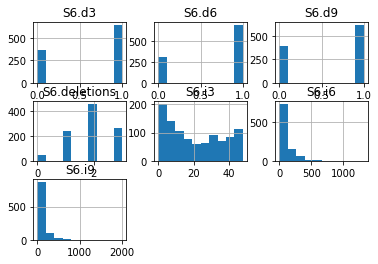

In [21]:
df_ins_freq.hist()

### Figure S7 - not currently in the paper
Reverse the data: how many mutations occer once, twice, three times etc.

In [22]:
def dna_mutation_frequencies(all_references):
    """
    Generate data for a histogram of DNA mutation frequencies - how many occur once, twice, ...
    :param all_references:
    :return:
    """
    freq = {}  # for each library ('d3', 'i6', etc.) give a dictionary {1: 5 times, 2: 3 times...}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            freq['.'.join([background,fraction])] = defaultdict(int)
            for prot_mutation, entry in all_references[background][fraction].items():
                for dna_mutation, dna_c in entry['dna'].items():
                    dna_mut_type = classify_dna(dna_mutation)
                    prot_mut_type = classify_protein(prot_mutation)
                    if dna_mut_type == fraction:
                        if prot_mut_type in dna_protein_correspondence(dna_mut_type):
                            freq['.'.join([background,fraction])][dna_c] += 1
                        elif dna_mut_type in ['d6']:
                            print('DNA:', dna_mut_type, dna_mutation, dna_c, 'PROTEIN:', prot_mutation)
                            print()
    return freq

hist_Poisson = dna_mutation_frequencies(all_ref)
df_hist_Poisson = pd.DataFrame(hist_Poisson, columns=fractions).fillna(0).astype('int32')
df_hist_Poisson.head()


DNA: d6 (('2', 'd', '6'),) 1 PROTEIN: ()

DNA: d6 (('27', 'd', '6'),) 1 PROTEIN: ()

DNA: d6 (('1002', 'd', '6'),) 1 PROTEIN: ((334, 's', 'W'), (335, 'd'))

DNA: d6 (('928', 'd', '6'),) 1 PROTEIN: ((310, 'd'), (311, 'd'), (335, 's', 'I'))



,S6.d3,S6.d6,S6.d9,S6.i3,S6.i6,S6.i9
1,30,30,30,5579,81421,93662
2,18,35,28,3424,17979,8469
3,23,23,16,2296,5049,1177
4,13,19,22,1787,1625,260
5,11,12,10,1294,574,90


In [23]:
df_hist_Poisson.sum()

S6.d3       639
S6.d6       690
S6.d9       613
S6.i3     20872
S6.i6    107165
S6.i9    103720
dtype: int64

index = number of times a mutation is observed

column = number of such mutations

This still needs manual clipping.

In [24]:
def plot_S7_Poisson(library,title, cutoffs, top_axes):
    
    # set the cutoffs betwen which we aggregate values, such that we count:
    # - 1, 2, 3, ... up to 49
    # - 50-74
    # - 75-99 etc.
    binned_counts = []
    hist_data = df_hist_Poisson[library].iloc[:cutoffs[0] + len(cutoffs)]
    main_max = df_hist_Poisson[library].max() # the axis for bottom group will cut off here

    for i in range(len(cutoffs) - 1 ):
        val = df_hist_Poisson[library].loc[cutoffs[i]:cutoffs[i+1]].sum()
        binned_counts.append(val)
        hist_data.iloc[[cutoffs[0] + i ]] = val
    # the last bin is open-ended and needs special handling
    hist_data.iloc[-1] = df_hist_Poisson[library].loc[cutoffs[-1]:].sum()
    binned_counts.append(df_hist_Poisson[library].loc[cutoffs[-1]:].sum())
    # this now contains the correct values, but labels are wrong
    # the labesls for aggregate bin need to be done separately anyway, so this is no issue
    
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 4]}, figsize=(8,5))

    f.suptitle(title)
    
    bins1 = list(range(1, cutoffs[0] + 1))
    bins2 = list(range(cutoffs[0]+6, cutoffs[0]+6 + 6*(len(cutoffs)), 6))
    bins =  bins1 + bins2
    ax.bar(bins, hist_data) # first arguement is x-position, second is height
    ax2.bar(bins, hist_data)

    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(top_axes[0], top_axes[1])  # outliers only
    ax2.set_ylim(0, main_max + 1)  # most of the data
    
    ax2.set_xlabel('Read count (X)')
    ax2.set_ylabel('Number of mutations')

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # set up the tick label positions and locatio

    xlabels_main_pos = list(range(0,cutoffs[0] + 1, 10))
    xlabels_main_pos[0] = 1 # first bin is one observation, not zero
    xlabels_main = [str(pos) for pos in xlabels_main_pos]
    
    xlabels_grouped = []
    for i in range(len(cutoffs)):
        xlabels_grouped.append(str(cutoffs[i] +1) + '+')
 
    xlabels = xlabels_main + xlabels_grouped
    xlabels_pos = xlabels_main_pos + bins2                    
    ax2.xaxis.set_ticks(xlabels_pos)
    ax2.set_xticklabels(xlabels)
    # hide the axes labels on top
    ax.axes.get_xaxis().set_visible(False) 


    # This looks pretty good, and was fairly painless, but you can get that
    # cut-out diagonal lines look with just a bit more work. The important
    # thing to know here is that in axes coordinates, which are always
    # between 0-1, spine endpoints are at these locations (0,0), (0,1),
    # (1,0), and (1,1).  Thus, we just need to put the diagonals in the
    # appropriate corners of each of our axes, and so long as we use the
    # right transform and disable clipping.

    d = .012  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-4*d, +4*d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-4*d, +4*d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

#     f.savefig('FigS7_' + library +'.png', format='png', dpi=600)
    plt.show()

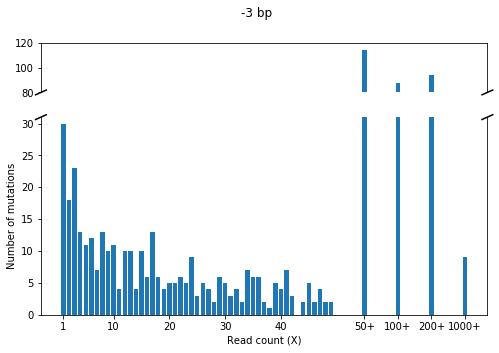

In [25]:
cutoffs = [49,99,199,999]
top_axes = [80,120]
plot_S7_Poisson('S6.d3', '-3 bp', cutoffs, top_axes) 

The insertion libraries have a simpler distribution, no split axes needed.

In [26]:
def plot_S7_Poisson_ins(library, cutoff,title):
    hist_data = df_hist_Poisson[library].iloc[:cutoff + 1]
    main_max = hist_data.max()
    axes_split = hist_data[2]
    after_trunc = df_hist_Poisson[library].iloc[cutoff:].sum()

    hist_data.iloc[cutoff] = after_trunc # that has the data with the last entry in series being cumulative

    
    f, ax2 = plt.subplots(1, figsize=(5,5))

    f.suptitle(title)
    
    bins = list(range(1, cutoff+1)) + [cutoff + 3]

    ax2.bar(bins,hist_data, color='purple')
 
    ax2.set_ylabel('Count (X)')
    ax2.set_xlabel('Number of mutations in library observed X-times')


    # set the tick label for overflow bin
    xlabels_pos = [1,2,3,4,5,6,7,8,9,10,12]
    xlabels = [str(pos) for pos in xlabels_pos]
    xlabels[-1] = str(cutoff) + '+'
    ax2.xaxis.set_ticks(xlabels_pos)
    ax2.set_xticklabels(xlabels)

    f.savefig('FigS7_' + library +'.png', format='png', dpi=600)
    plt.show()





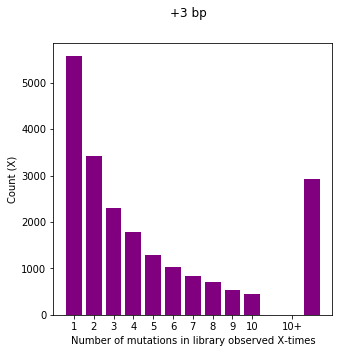

In [27]:
plot_S7_Poisson_ins('S6.i3', 10, '+3 bp') 

In [28]:
def insertion_composition(all_references, cutoff=2, l=(3,6,9)):

    comp = {length: {k: {'A':0, 'C':0, 'T':0, 'G':0} for k in range(length)} for length in l}
    for background in all_references.keys():
        for fraction in all_references[background].keys():
            for mutation in all_references[background][fraction].keys():
                for dna_error, c in all_references[background][fraction][mutation]['dna'].items():
                    if dna_error is None:
                        continue
                    if c >= cutoff and len(dna_error) == 1 and classify_dna(dna_error) in ('i3', 'i6', 'i9'):
                        ins = dna_error[0][2]
                        ins_len = len(ins)
                        if ins_len in l:
                            for pos in range(ins_len):
                                comp[ins_len][pos][ins[pos]] += 1
    return comp


# # 4. Get position by position ACGT composition of insertions - SI Figure
ins_composition = insertion_composition(all_ref)
print('ACGT composition of insertions, for each position separately')
pprint.pprint(ins_composition)
print()
#

ACGT composition of insertions, for each position separately
{3: {0: {'A': 4586, 'C': 3076, 'G': 3827, 'T': 3840},
     1: {'A': 4359, 'C': 3328, 'G': 3434, 'T': 4208},
     2: {'A': 3531, 'C': 3643, 'G': 3094, 'T': 5061}},
 6: {0: {'A': 5057, 'C': 4941, 'G': 9202, 'T': 6622},
     1: {'A': 5046, 'C': 5273, 'G': 8572, 'T': 6931},
     2: {'A': 4982, 'C': 5071, 'G': 8194, 'T': 7575},
     3: {'A': 5427, 'C': 4955, 'G': 7761, 'T': 7679},
     4: {'A': 5596, 'C': 4631, 'G': 8005, 'T': 7590},
     5: {'A': 3627, 'C': 5589, 'G': 6323, 'T': 10283}},
 9: {0: {'A': 2122, 'C': 1903, 'G': 3591, 'T': 2443},
     1: {'A': 2070, 'C': 2193, 'G': 3208, 'T': 2588},
     2: {'A': 1992, 'C': 2139, 'G': 3128, 'T': 2800},
     3: {'A': 2153, 'C': 2145, 'G': 3007, 'T': 2754},
     4: {'A': 2042, 'C': 2208, 'G': 3092, 'T': 2717},
     5: {'A': 2089, 'C': 2032, 'G': 2948, 'T': 2990},
     6: {'A': 2156, 'C': 1844, 'G': 3019, 'T': 3040},
     7: {'A': 2228, 'C': 1776, 'G': 3087, 'T': 2968},
     8: {'A': 1496

### Figure 6C box charts

In [29]:
col_list = ['-3 bp', '-6 bp', '-9 bp', '+3 bp', '+6 bp', '+9 bp']
df_triad = pd.read_csv('Fig6C.csv', usecols=col_list).loc[0:177]
df_triad_log = np.log10(df_triad)
df_trinex = pd.read_csv('Fig6C.csv', usecols=['TriNEx'])
df_trinex_log = np.log10(df_trinex)

In [30]:
indel_dark = sns.color_palette( ['#dd0806', '#dd0806', '#dd0806', '#6815d4', '#6815d4', '#6815d4'] )
indel_light = sns.color_palette( ['#ffc3c4', '#ffc3c4', '#ffc3c4', '#cba2ff', '#cba2ff', '#cba2ff'])
col_subs = ['#02c6ff', '#aaecff']

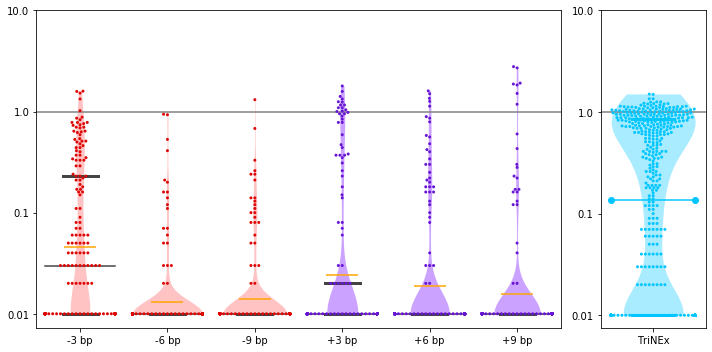

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize=(10,5))

# the TRIAD library plot on the left
ax = ax1

sns.violinplot(data = df_triad_log, inner=None, palette = indel_light,  
                   saturation = 1, linewidth=0, cut=0.01, ax = ax)
sns.boxplot(data = df_triad_log, ax = ax, whis = 0,
            showcaps=True, showbox=False, showfliers=False, palette = indel_dark,
            capprops = {'linewidth': 3},)
sns.swarmplot(data=df_triad_log, ax = ax, palette = indel_dark, linewidth=0, size=3)

# add geometric means
gmeans = np.log10(st.gmean(df_triad))
inds = np.arange(len(gmeans))
ax.scatter(inds, gmeans, marker='_', color='orange', s=1000)

# TriNEx library separate
ax = ax2
sns.violinplot(data=df_trinex_log, inner=None, color = col_subs[1],  
                   saturation = 1, linewidth=0, cut=0.01, ax = ax)
sns.boxplot(data = df_trinex_log, ax = ax, whis = 0, usermedians = np.log10(st.gmean(df_trinex)),
            showcaps=True, showbox=False, showfliers=False,
            capprops = {'color': col_subs[0], 'linewidth': 3},
            medianprops = {'color': col_subs[0], 'marker': 'o'})
sns.swarmplot(data=df_trinex_log, ax = ax, color=col_subs[0], linewidth=0, size=3)

for ax in (ax1, ax2):
    ax.set_yticks(np.arange(-2, 2))
    ax.set_yticklabels(10.0**np.arange(-2, 2))
    ax.axhline(0, color = 'gray')

plt.tight_layout()
plt.savefig('Fig6C.svg')
plt.show()